# Computing decision boundary for geometric examples in dimension 2 and 3

In this notebook we will use gradient flow from gdeep.decision_boundary to compute the decision boundary of a neural network trained on a binary classification problem

In [99]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import math

seed=42

import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F


from gtda.plotting import plot_point_cloud


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import pandas as pd
import plotly.express as px

from gdeep.decision_boundary import *
from gdeep.neural_nets import Net
from gdeep.neural_nets.utility import train_classification_nn
from gdeep.create_data.tori import make_torus_point_cloud, Rotation

## Example 1: Decision boundary for two circles in $\mathbb R^2$

We have constructed two data sets $A$ and $B$ with the labels $0$ and $1$. These are either concentric or separated from one another by adding `[2,0]` or not.

In [41]:
data, label = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=seed)

A = data[label==0]
B = data[label==1] #+ [2,0]

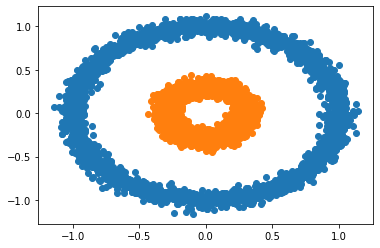

In [127]:
plt.scatter(A[:,0], A[:,1])
plt.scatter(B[:,0], B[:,1])
plt.show()

In [62]:
# define fully connected NN architecture
circle_detect = Net(0, [2,10,10])

# transform input data to 
X_train = torch.from_numpy(np.concatenate((A, B))).float()
y_train = torch.from_numpy(np.concatenate((np.ones(A.shape[0]),\
                np.zeros(B.shape[0])))).float()


# Train neural net on binary classification task
train_classification_nn(circle_detect, X_train, y_train, n_epochs=1000)

99 0.9412509799003601
199 0.6686216592788696
299 0.5377398729324341
399 0.3568928837776184
499 0.20962001383304596
599 0.12312001734972
699 0.07569002360105515
799 0.049490395933389664
899 0.034263692796230316
999 0.024776391685009003


We will uniformely distribute points in the box `[(-1,1),(-1,1)]` and we pull push these point `x_i` in the opposite direction of the gradient of gradient of `(Net(x_i)-0.5)^2`. This will be done `n_epochs` times.

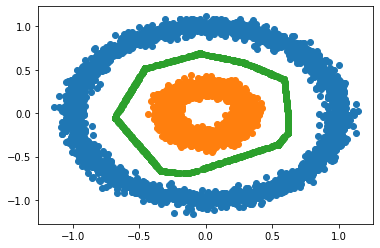

In [128]:
sample_points_boundary = gradient_flow(circle_detect, boundary_tuple=[(-1,1),(-1,1)])

# Plot the data set and the computed decision boundary
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1])
plt.scatter(sample_points_boundary[:,0],sample_points_boundary[:,1])

plt.show()

We can verify our result by looking at the contour plot of the neural net.

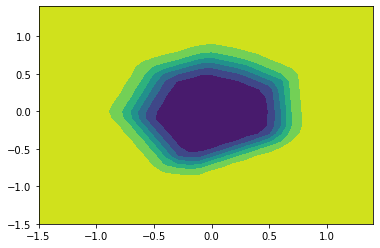

In [68]:
# Plot graph of circle_detect

delta = 0.1
x = np.arange(-1.5, 1.5, delta)
y = np.arange(-1.5, 1.5, delta)
X, Y = np.meshgrid(x, y)

X_tensor, Y_tensor = torch.from_numpy(X).float(), torch.from_numpy(Y).float()
X_tensor = X_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1],1))
Y_tensor = Y_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1],1))
XY_tensor = torch.cat((X_tensor,Y_tensor), 2)

XY_tensor = XY_tensor.reshape((-1,2))

Z_tensor = circle_detect.forward(XY_tensor)
Z_tensor = Z_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1]))
Z = Z_tensor.detach().numpy()
plt.contourf(X, Y, Z)


## Example 2: Decision boundary for two tori in $\mathbb R^3$

We will first generate a binary data set with two unentanbled tori in $\mathbb R^3$ and similarly for two entanbled tori.

The point clouds for the tori and the lables are stored in a dictionary.

In [140]:
torus_point_cloud = {'ent': {0: {}, 1: {}}, 'unent': {0: {}, 1: {}}}
torus_labels = {'ent': {0: {}, 1: {}}, 'unent': {0: {}, 1: {}}}

# Generate torus point cloud for unentangled tori
torus_point_cloud['unent'][0], torus_labels['unent'][0] = make_torus_point_cloud(0, 50, 0.0,\
    Rotation(1,2,math.pi/2), np.array([[0,0,0]]), radius=.3)
torus_point_cloud['unent'][1], torus_labels['unent'][1]  = make_torus_point_cloud(1, 50, 0.0,\
    Rotation(1,2,0), np.array([[6,0,0]]), radius=.3)

# Generate torus point cloud for unentangled tori
torus_point_cloud['ent'][0], torus_labels['ent'][0] = make_torus_point_cloud(0, 50, 0.0,\
    Rotation(1,2,math.pi/2), np.array([[0,0,0]]), radius=.3)
torus_point_cloud['ent'][1], torus_labels['ent'][1]  = make_torus_point_cloud(1, 50, 0.0,\
    Rotation(1,2,0), np.array([[2,0,0]]), radius=.3)


# Concatenate torus point clouds
tori_point_cloud = {}
tori_labels = {}

for config in ['ent', 'unent']:
    tori_point_cloud[config] = np.concatenate((torus_point_cloud[config][0],\
                                torus_point_cloud[config][1]), axis=0)
    tori_labels[config] = np.concatenate((torus_labels[config][0],\
                                torus_labels[config][1]), axis=0)

# Plot data sets
df_tori = {}

for config in ['ent', 'unent']:
    df_tori[config] = pd.DataFrame(tori_point_cloud[config], columns = ["x", "y", "z"])
    fig = px.scatter_3d(df_tori[config], x="x", y="y", z="z", color=tori_labels[config], title="Tori "+config+"angled")
    fig.show()

In the next step we will train fully connected neural networks on the binary classification task.

In [119]:
# Define neural network architecture
tori_detect_nn = {}
tori_detect_nn['unent'] = Net(0, [3,20,20,20,20])
tori_detect_nn['ent'] = Net(0, [3,20,20,20,20])

X_train = {}
y_train = {}

# Define X_train and y_train for ent and unent simultaneously
for config in ['ent', 'unent']:
    X_train[config] = torch.from_numpy(tori_point_cloud[config]).float()
    y_train[config] = torch.from_numpy(tori_labels[config]).float()

# Print the architecture of both neural nets
for config in ['ent', 'unent']:
    print('Architecture of Neural Net for ' + config + 'angled:\n', tori_detect_nn[config])

# Train neural neural nets on data sets
for config in ['ent', 'unent']:
    print('Training of Neural Net for ' + config + 'angled')
    train_classification_nn(tori_detect_nn[config], X_train[config], y_train[config], n_epochs=2000)

Architecture of Neural Net forentangled:
 Net(
  (layer0): Linear(in_features=3, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=1, bias=True)
)
Architecture of Neural Net forunentangled:
 Net(
  (layer0): Linear(in_features=3, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=1, bias=True)
)
Training of Neural Net forentangled
99 0.0962982103228569
199 0.02858353964984417
299 0.010230296291410923
399 0.004460626747459173
499 0.0023404541425406933
599 0.0014063718263059855
699 0.0009236181504093111
799 0.0006493098335340619
899 0.00048123608576133847
999 0.00030

As in the first example we will sample points in a box and let them flow in the direction of the decison boundary using our gradient flow method.

In [132]:
# Apply gradient flow to detect decision boundary
n_samples = 10000

boundary_tuple = {}

boundary_tuple['ent']   = [(-2, 4), (-2, 2), (-2, 2)]
boundary_tuple['unent'] = [(-3, 7), (-2, 2), (-2, 2)]

sample_points_boundary = {}

for config in ['ent', 'unent']:
    sample_points_boundary[config] = gradient_flow(tori_detect_nn[config],\
        boundary_tuple[config], n_samples=n_samples)


In the last step we plot the data set and the computed decision boundary

In [139]:
# visualisation
save_to_file = True


# Pandas data frame for the decision boundary
df_bd = {}

for config in ['ent', 'unent']:
    df_bd[config] = pd.DataFrame(sample_points_boundary[config], columns = ["x", "y", "z"])

# Pandas data frame for the tori data sets and the decision boundary
df_dt_db = {}

for config in ['ent', 'unent']:
    df_dt_db[config] = pd.concat([df_tori[config], df_bd[config]])

# Plot tori data sets and the decision boundary
# If save_to_file is set to True we will save the plots in an html
for config in ['ent', 'unent']:
    fig = px.scatter_3d(df_dt_db[config], x="x", y="y", z="z", color=np.concatenate(\
        (0*np.ones(torus_point_cloud[config][0].shape[0]),\
        1*np.ones(torus_point_cloud[config][1].shape[0]),\
        2*np.ones(df_bd[config].shape[0]))),\
        title="Tori "+config+"angled with decision boundary of NN")
    if save_to_file:
        fig.write_html("outputs/decision_boundary"+ config +"angled_tori.html")
    fig.show()

## Density of decision boundary points

too be written

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html


![](images/density_point_cloud.png)

